In [1]:
import numpy as np
import pandas as pd

import h5py

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
import sklearn.metrics as metric

import math

In [4]:
#Make sure the metadata file exactly matches with the enformer output file. Otherwise the indices for the recipient and donor file in the metdata csv
#will not match the actual data from these files in the enformer output. 
targets_txt = "/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/metadataFiles/enformer_output_validation_class_balanced.csv"
metadata_df = pd.read_csv(targets_txt, sep='\t')
metadata_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/metadataFiles/enformer_output_validation_class_balanced.csv'

: 

In [2]:
#If we want to get the data from only 2 files. 
#We need to make a PCA plot for only one patient - so the data from donor and recipient files of L41-M27
#From the metadata file, get the indices corresponding to these 2 files. Extract only these indices from the enformer output h5py file.
targetFile1 = "/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/coordinateFiles170000/L41-M27.recipient.hdf5"
targetFile2 = "/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/coordinateFiles170000/L41-M27.donor.hdf5"
enformerOutputFile = "/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/EnformerOutputs/enformer_output_validation_270000.hdf5"

recipientIndices = metadata_df.index[metadata_df['og_file'] == targetFile1].tolist()
num_recip = len(recipientIndices)
donorIndices = metadata_df.index[metadata_df['og_file'] == targetFile2].tolist()
num_donor = len(donorIndices)
print(f"number of donor and recipient samples to be plotted is {num_donor} and {num_recip}")

#Now pick all values from the enformer output h5py file that match these indices
with h5py.File(enformerOutputFile, 'r') as f:
    fullDonorSamples = f["validationEnformerOutput"][:][donorIndices]
    fullRecipientSamples = f["validationEnformerOutput"][:][recipientIndices]
    print(fullDonorSamples.shape)
    print(fullRecipientSamples.shape)

NameError: name 'metadata_df' is not defined

In [3]:
enformerOutputFile = "/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/EnformerOutputs/enformer_output_validation_270000.hdf5"
with h5py.File(enformerOutputFile, 'r') as f:
    fullDonorSamples = f["validationEnformerOutput"][:]
    fullRecipientSamples = f["validationEnformerOutput"][:]
    print(fullDonorSamples.shape)
    print(fullRecipientSamples.shape)

(64384, 10626)
(64384, 10626)


In [ ]:
def getPcaDataForPlotting(n_components, pcaColumnNames, all_donor_samples, all_recip_samples, num_donor_samples = False, num_recip_samples = False, plotPcaExplainedVariance = False):
    num_donor_samples = len(all_donor_samples)
    num_recip_samples = len(all_recip_samples)
    combined_samples = np.vstack((all_donor_samples, all_recip_samples))

    columnNames = []
    for i in range(1, 10627):
        columnNames.append("EnformerTrack" + str(i))

    donor_recip_enformer_tracks_df = pd.DataFrame(combined_samples, columns = columnNames)
    donor_recip_enformer_tracks_df_scaled = StandardScaler().fit_transform(donor_recip_enformer_tracks_df)

    pca = PCA(n_components)

    #This will create a numpy array with only 3 columns inplace of 10626 columns 
    pca_features = pca.fit_transform(donor_recip_enformer_tracks_df_scaled)

    if(plotPcaExplainedVariance):
        plotPcaExplainedVarianceBarGraph(pca)

    pca_df = pd.DataFrame(data = pca_features, columns = pcaColumnNames)

    #Set target and target names in the PCA df 
    pca_df.loc[0:num_donor_samples-1, "target"] = 1
    pca_df.loc[0:num_donor_samples-1, "target_name"] = "donor"
    pca_df.loc[num_donor_samples:num_donor_samples + num_recip_samples - 1, "target"] = 0
    pca_df.loc[num_donor_samples:num_donor_samples + num_recip_samples -1, "target_name"] = "recipient"
    return pca, pca_df

def plotPcaExplainedVarianceBarGraph(pca):
    n_features = range(pca.n_components_)
    plt.bar(n_features, pca.explained_variance_ratio_, color='black')
    plt.xlabel('PCA features')
    plt.ylabel('variance %')
    plt.xticks(n_features)

def plotPcaData(pca, pca_df, n_components, columnNames):
    x = pca_df[columnNames[0]]
    y = pca_df[columnNames[1]]

    col_1_variance = round(pca.explained_variance_ratio_[0], 2)
    col_2_variance = round(pca.explained_variance_ratio_[1], 2)
    col_3_variance = round(pca.explained_variance_ratio_[2], 2)

    fig = plt.figure()

    if(n_components == 3):
        ax = fig.add_subplot(111, projection = "3d")

        ax.set_xlabel(columnNames[0] + "(" + str(col_1_variance) + ")")
        ax.set_ylabel(columnNames[1] + "(" + str(col_2_variance) + ")")
        ax.set_zlabel(columnNames[2] + "(" + str(col_3_variance) + ")")

        donor_pca = pca_df.loc[pca_df['target_name'] == "donor"]
        z = donor_pca[columnNames[2]]
        x = donor_pca[columnNames[0]]
        y = donor_pca[columnNames[1]]
        
        plt.scatter(x, y, z, color='red', alpha = 0.5)

        recip_pca = pca_df.loc[pca_df['target_name'] == "recipient"]
        z = recip_pca[columnNames[2]]
        x = recip_pca[columnNames[0]]
        y = recip_pca[columnNames[1]]
        
        plt.scatter(x, y, z, color='blue', alpha = 0.5)

        plt.title(f"3D PCA graph of enformer outputs : {len(pca_df)} samples")
        plt.show()
    
    if(n_components == 2):
        ax = fig.add_subplot(111)
        ax.set_xlabel(columnNames[0] + "(" + str(col_1_variance) + ")")
        ax.set_ylabel(columnNames[1] + "(" + str(col_2_variance) + ")")

        donor_pca = pca_df.loc[pca_df['target_name'] == "donor"]
        x = donor_pca[columnNames[0]]
        y = donor_pca[columnNames[1]]
        
        plt.scatter(x, y, color='red', alpha = 0.5)

        recip_pca = pca_df.loc[pca_df['target_name'] == "recipient"]
        x = recip_pca[columnNames[0]]
        y = recip_pca[columnNames[1]]
        
        plt.scatter(x, y, color='blue', alpha = 0.5)

        plt.title(f"2D PCA graph of enformer outputs : {len(pca_df)} samples")
        plt.show()
    
    if(n_components != 3 and n_components != 2):
        print("Only 2D and 3D plots are supported. Give n_components argument as 2 or 3")

In [5]:
#Plot the percentage explained variance for 3 principal axes PCA for all samples. 
pca_df_column_names = []
for i in range(1, 101):
    pca_df_column_names.append("PC" + str(i))

pca, pca_df = getPcaDataForPlotting(100, pca_df_column_names, fullDonorSamples, fullRecipientSamples, False, False, False)
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,target,target_name
0,-9.937537,18.024221,-4.561569,-1.526847,16.083315,25.277132,-25.535706,17.562473,-10.857132,11.518251,...,-2.565012,-1.258147,2.120699,1.084707,3.313102,-1.694024,0.833381,-0.859380,1.0,donor
1,118.669937,7.648469,12.360788,-37.609524,-26.745106,39.941830,-16.328030,22.026817,12.963615,-3.998231,...,0.581003,5.570842,-0.492388,0.960925,1.248759,1.077727,-4.409040,3.090677,1.0,donor
2,-41.031452,0.236004,-0.266551,7.593162,5.318150,-9.281301,-1.079028,-3.571095,-3.559256,-6.238796,...,-0.406904,-0.101038,-0.888610,-0.819685,0.287277,0.071177,-0.572086,0.741007,1.0,donor
3,-35.647011,-5.464135,-2.904938,0.823285,1.106904,4.942662,-0.044377,4.342091,-1.175632,4.072304,...,-0.653212,0.066687,1.587837,-0.537622,-0.069417,-0.318233,0.227196,0.310259,1.0,donor
4,-14.289624,-13.622703,-8.803522,23.614813,18.294655,-28.175320,12.027551,-2.491493,-18.409155,-19.175880,...,1.525168,-0.680521,-3.375759,-0.513114,2.926577,0.258599,-0.629527,0.245552,1.0,donor


AttributeError: 'Axes' object has no attribute 'set_zlabel'

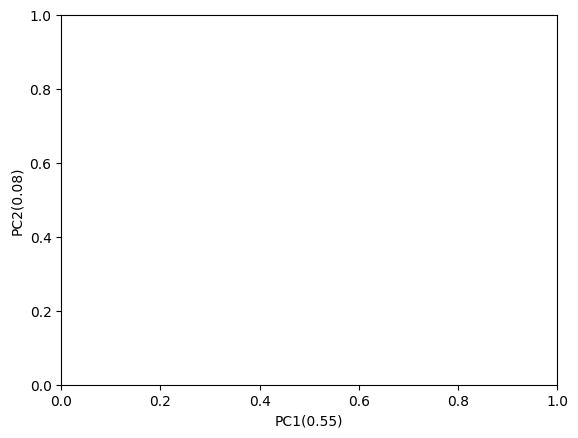

In [17]:
column_names_3d = ["PC1", "PC2", "PC3"]
plotPcaData(pca, pca_df, 3, column_names_3d)

column_names_2d = ["PC1", "PC2", "PC3"]
plotPcaData(pca, pca_df, 2, column_names_2d)

In [11]:
#We have a total of ~50k samples for the file chosen. If all these points are plotted together, then the graph becomes too cluttered.
column_names_3d = ["PC1", "PC2", "PC3"]
column_names_2d = ["PC1", "PC2"]
pca_df_3d_all = getPcaDataForPlotting(3, column_names_3d, fullDonorSamples, fullRecipientSamples)
pca_df_2d_all = getPcaDataForPlotting(2, column_names_2d, fullDonorSamples, fullRecipientSamples)

# pca_df_3d_1000 = getPcaDataForPlotting(3, column_names_3d, fullDonorSamples, fullRecipientSamples, 1000, 1000)
# pca_df_2d_1000 = getPcaDataForPlotting(2, column_names_2d, fullDonorSamples, fullRecipientSamples, 1000, 1000)

# pca_df_3d_500 = getPcaDataForPlotting(3, column_names_3d, fullDonorSamples, fullRecipientSamples, 500, 500)
# pca_df_2d_500 = getPcaDataForPlotting(2, column_names_2d, fullDonorSamples, fullRecipientSamples, 500, 500)

# pca_df_3d_100 = getPcaDataForPlotting(3, column_names_3d, fullDonorSamples, fullRecipientSamples, 100, 100)
# pca_df_2d_100 = getPcaDataForPlotting(2, column_names_2d, fullDonorSamples, fullRecipientSamples, 100, 100)

# pca_df_3d_50 = getPcaDataForPlotting(3, column_names_3d, fullDonorSamples, fullRecipientSamples, 50, 50)
# pca_df_2d_50 = getPcaDataForPlotting(2, column_names_2d, fullDonorSamples, fullRecipientSamples, 50, 50)

ValueError: Found array with 0 sample(s) (shape=(0, 10626)) while a minimum of 1 is required by StandardScaler.

In [ ]:
#Plot the explained variance for each of the principal component axes
principalComponents = pca.fit_transform(X_std)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

Colours is 0        blue
1        blue
2        blue
3        blue
4        blue
         ... 
50989    pink
50990    pink
50991    pink
50992    pink
50993    pink
Name: target_name, Length: 50994, dtype: object


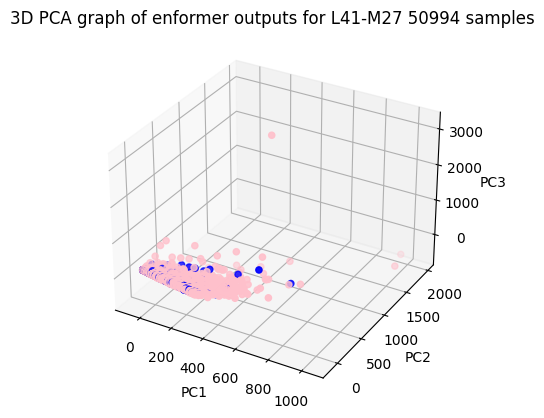

Colours is 0       blue
1       blue
2       blue
3       blue
4       blue
        ... 
1993    pink
1994    pink
1995    pink
1996    pink
1997    pink
Name: target_name, Length: 1998, dtype: object


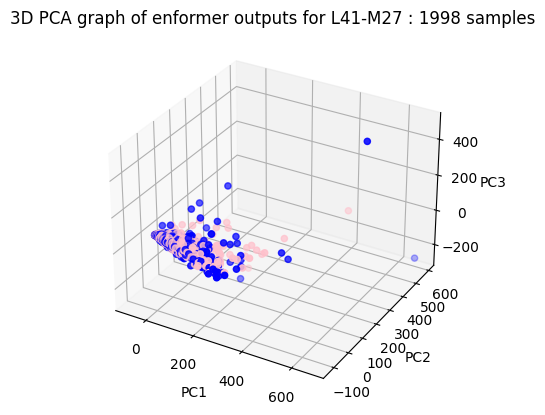

In [13]:
plotPcaData(pca_df_3d_1000, 3, column_names_3d)

Colours is 0      blue
1      blue
2      blue
3      blue
4      blue
       ... 
993    pink
994    pink
995    pink
996    pink
997    pink
Name: target_name, Length: 998, dtype: object


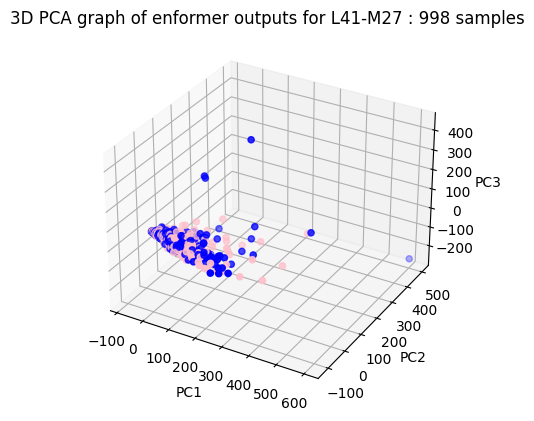

In [14]:
plotPcaData(pca, pca_df_3d_500, 3, column_names_3d)

Colours is 0      blue
1      blue
2      blue
3      blue
4      blue
       ... 
193    pink
194    pink
195    pink
196    pink
197    pink
Name: target_name, Length: 198, dtype: object


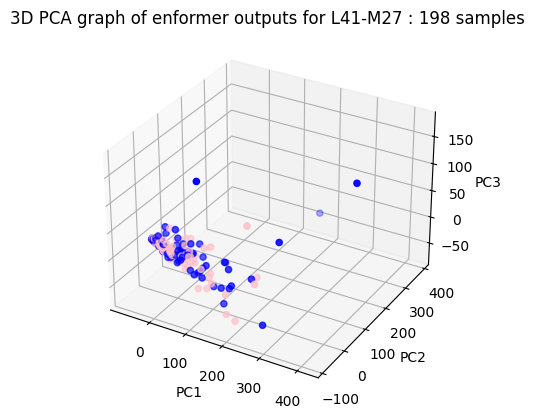

In [15]:
plotPcaData(pca_df_3d_100, 3, column_names_3d)

Colours is 0     blue
1     blue
2     blue
3     blue
4     blue
      ... 
93    pink
94    pink
95    pink
96    pink
97    pink
Name: target_name, Length: 98, dtype: object


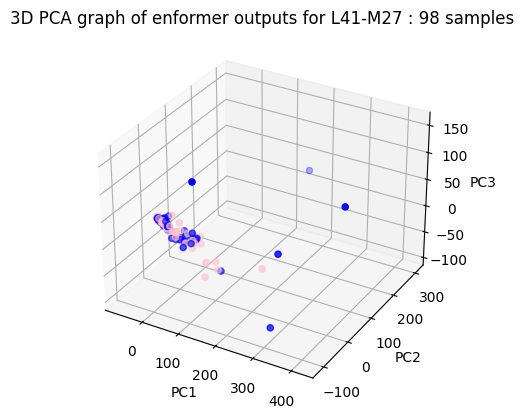

In [16]:
plotPcaData(pca_df_3d_50, 3, column_names_3d)

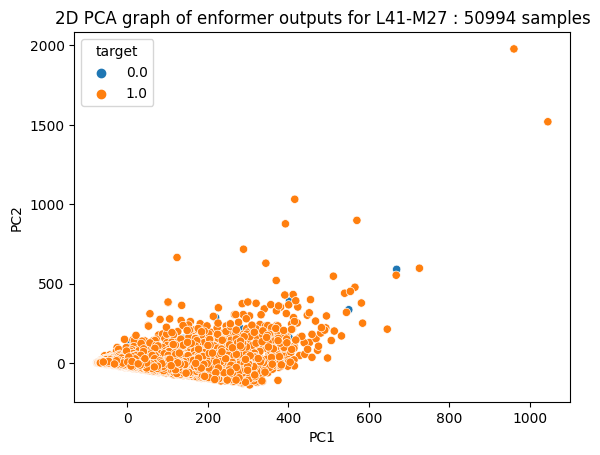

In [17]:
plotPcaData(pca_df_2d_all, 2, column_names_2d)

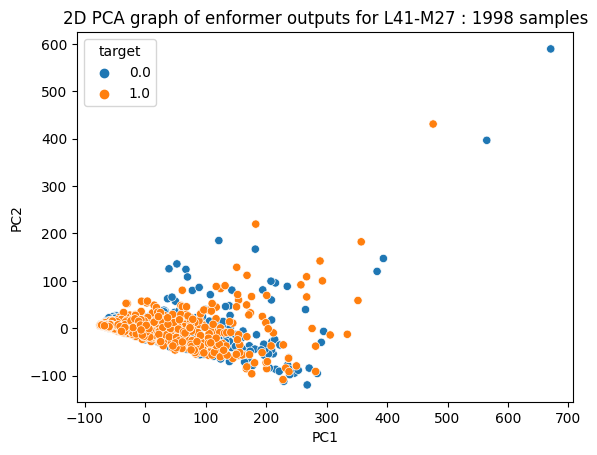

In [18]:
plotPcaData(pca_df_2d_1000, 2, column_names_2d)

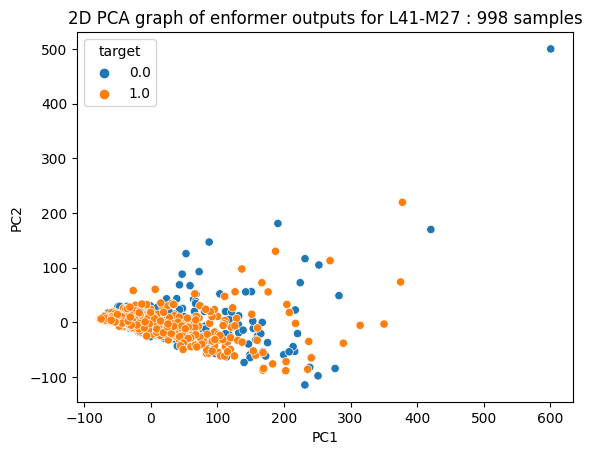

In [19]:
plotPcaData(pca_df_2d_500, 2, column_names_2d)

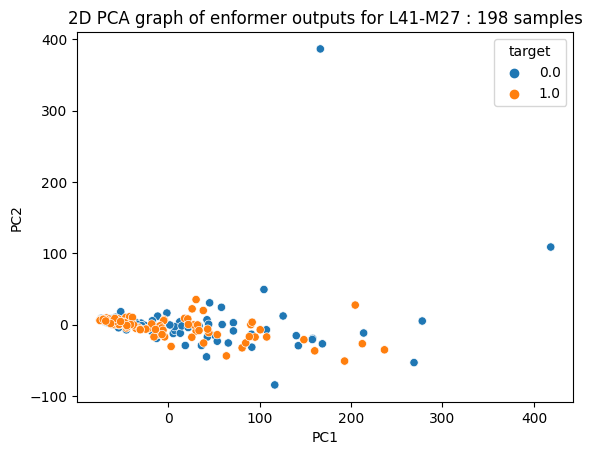

In [20]:
plotPcaData(pca_df_2d_100, 2, column_names_2d)

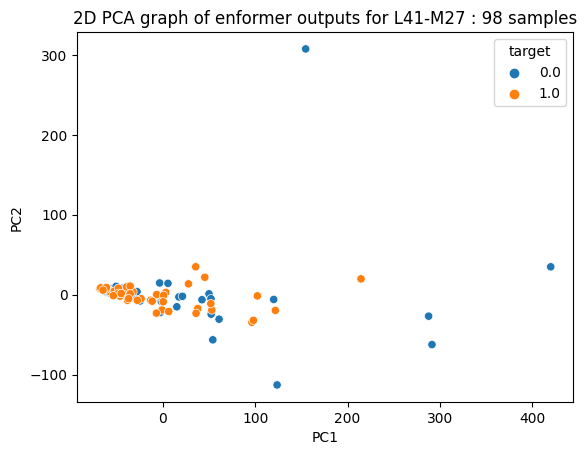

In [21]:
plotPcaData(pca_df_2d_50, 2, column_names_2d)

In [66]:
def train_test_split(df, num_donors, num_recip, train_percentage):
    num_train_donor = math.floor(train_percentage * num_donors / 100)
    num_train_recip = math.floor(train_percentage * num_recip / 100)
    print(f"Train D and R {num_train_donor} and {num_train_recip}")
    train_donor_samples = df.iloc[0: num_train_donor - 1, :]
    test_donor_samples = df.iloc[num_train_donor: num_donors - 1, :]
    
    train_recip_samples = df.iloc[num_donors: num_donors + num_train_recip - 1, :]
    test_recip_samples = df.iloc[num_donors + num_train_recip : num_donors + num_recip - 1, :] 
    
    train_samples = pd.concat([train_donor_samples, train_recip_samples], axis = 0, ignore_index = True)
    test_samples = pd.concat([test_donor_samples, test_recip_samples], ignore_index = True, axis = 0)

    return train_samples, test_samples

In [67]:
#Split the PCA df such that 80% of donor samples and 80% of recipient samples belong to the train set.
num_donors = len(pca_df_3d_all[pca_df_3d_all["target"] == 0])
num_recip = len(pca_df_3d_all[pca_df_3d_all["target"] == 1])
print(f"Num donors and num recips are {num_donors} and {num_recip}")
train_pca, test_pca = train_test_split(pca_df_3d_all, num_donors, num_recip, 80)

#These are of the type pandas series. 
labels_train = train_pca["target"]
labels_test = test_pca["target"]

train_pca.drop(columns=['target', 'target_name'])
test_pca.drop(columns=["target", "target_name"])
#test_pca and train_pca are of type dataframe 

#Train a logistic regression model on PCA data 
# model = sm.Logit(labels_train, train_pca).fit()
# predictions = model.predict(test_pca)
# accuracy = metric.accuracy_score(labels_test, predictions)

# print(f"Accuracy of of predictions is {accuracy}")

Num donors and num recips are 2960 and 48034
Train D and R 2368 and 38427
Type labels train <class 'pandas.core.series.Series'>
Test labels type <class 'pandas.core.series.Series'>
Type of train pca <class 'pandas.core.frame.DataFrame'>


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [72]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import sklearn.metrics as metric
import statsmodels.api as sm

cancer = load_breast_cancer()

data = pd.DataFrame(data = cancer["data"], columns = cancer["feature_names"])
data["y"] = cancer["target"]
# data.head()

x = data["mean symmetry"]
x = sm.add_constant(x)
y = data['y']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state = 101)
print(f"Types are {type(x_train)}, {type(y_train)}")
model = sm.Logit(y_train, x_train).fit()
x_train.head()
# y_train.head()


Types are <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.series.Series'>
Optimization terminated successfully.
         Current function value: 0.592016
         Iterations 6


,const,mean symmetry
178,1.0,0.1395
421,1.0,0.2086
57,1.0,0.2027
514,1.0,0.1561
548,1.0,0.1580
